# The *dalton* plots

In this notebook we conduct some analyses regarding the distibutions    
of counts of ATACseq peaks inside genomic regions assigned to genes.    
These are most often GREAT regions (see relevant notebook)   
    
We separate the data in various meaningful ways and plot the distributions    
with boxplots.

# Definition of trans-dev and housekeeping genes
Orthologous clusters of trans-dev genes (i.e. genes implicated in transcriptional regulation or development were defined based on the GO annotations for the mouse orthologs. We downloaded GO annotations for mouse from Ensembl Biomart (release 80) and defined trans-dev genes as those with: (i) GO:0009790 (embryo development) and/or GO:0030154 (cell differentiation) Biological Process annotations; and (ii) GO:0043565 (sequence-specific DNA binding), GO:0007267 (cell-cell signaling) and/or GO:0008380 (RNA splicing) Molecular Function annotations. In contrast, mouse housekeeping genes were defined as those with a 1-to-1 ortholog with yeast (Saccharomyces cerevisiae) based on Ensembl Biomart, and that did not have GO:0009790 (embryo development) or GO:0030154 (cell differentiation) Biological Process annotations. After assigning these categories to the mouse genes, the annotations were transferred to all genes from the same orthologous group, including homologs from other species and their paralogs. This resulted in a total of 654/817, 809/916, 680/805 and 362/865 trans-dev/housekeeping genes in mouse, zebrafish, medaka and amphioxus, respectively (Supplementary Dataset 10).

## Data loading and handling

In [3]:
# This is a dictionary containing dataframes with the GREAT regions of each 
# species
greg = gr_great
#how many genes in each species:
print( [(k,len(v)) for k,v in greg.items()])

[('Dre', 20053), ('Bla', 20569), ('Ola', 15978), ('Mmu', 18842)]


for each species we have a dataframe in there, each gene is assigned a genomic region for GREAT regions those might overlap. Using this in the later steps we will count the number of ATACseq peaks in the region of each gene 

In [4]:
greg['Mmu'].head(3)

chrom    start      end              geneID    score strand
0  chr1  2670503  4359310  ENSMUSG00000051951  1688807      -
1  chr1  3676503  4495409  ENSMUSG00000025900   818906      -
2  chr1  4365319  4784706  ENSMUSG00000025902   419387      -

In [5]:
# busywork
stages = {}
stages['Bla'] = ['8','15','36','60']
stages['Dre'] = ["dome","shield","80epi","8som","24h","48h"]
stages['Ola'] = ["dome","shield","8som","24h","48h"]
stages['Mmu'] = ['DE','ESC']

In [6]:
#load the ATACseq peaks
peak_beds = {}
peak_beds['Dre'] = [ (BT(zebra_idr(x))
                    .sort()
                    )for x in stages['Dre']]
peak_beds['Bla'] = [(BT(amphi_idr(x))
                     .sort()
                     ) for x in stages['Bla']]
peak_beds['Ola'] = [ (BT(medaka_idr(x))
                    .sort()
                    )for x in stages['Ola']]
peak_beds['Mmu'] = [ (BT(mouse_idr(x))
                    .sort()
                    )for x in stages['Mmu']]

In [7]:
stagespecorder = ['bla_8','bla_15','bla_36','bla_60',' ',
 'dre_dome','dre_shield','dre_80epi','dre_8som','dre_24h','dre_48h',' ',
 'ola_dome','ola_shield','ola_8som','ola_24h','ola_48h',' ',
 'mmu_ESC','mmu_DE'
]

We will use the following to split genes in genomic categories  
according to how many gene copies are found in mouse  
by making some masks for the dataframe  

In [8]:
mask_oto = (genefamsC['Bla']==1) & (genefamsC['Mmu']==1)  # 1-1
mask_ottw = (genefamsC['Bla']==1) & (genefamsC['Mmu']==2) # 1-2
mask_otth = (genefamsC['Bla']==1) & (genefamsC['Mmu']==3) # 1-3
mask_otfo = (genefamsC['Bla']==1) & (genefamsC['Mmu']==4) # 1-4

masks = [mask_oto, mask_ottw,mask_otth,mask_otfo]
titles = ['1-1','1-2','1-3','1-4']
# then some sets
oto_genes = genefams.loc[mask_oto,['Bla','Dre','Mmu','Ola']]
oto_genes = set([x for y in oto_genes.values.flatten() if y==y for x in y])
ottw_genes = genefams.loc[mask_ottw,['Bla','Dre','Mmu','Ola']]
ottw_genes = set([x for y in ottw_genes.values.flatten() if y==y for x in y])
otth_genes = genefams.loc[mask_otth,['Bla','Dre','Mmu','Ola']]
otth_genes = set([x for y in otth_genes.values.flatten() if y==y for x in y])
otfo_genes = genefams.loc[mask_otfo,['Bla','Dre','Mmu','Ola']]
otfo_genes = set([x for y in otfo_genes.values.flatten() if y==y for x in y])
# and use the sets to categorize the genes inside the dataframe
def categorize(x):
    if x in oto_genes:
        return '1-1'
    elif x in ottw_genes:
        return '1-2'
    elif x in otth_genes:
        return '1-3'
    elif x in otfo_genes:
        return '1-4'
    else:
        return 'nop'

We intersect the GREAT file with the ATACpeaks files  
 to count peaks inside the region of each gene  
This is essentially a bedtools intersect (using pybedtools)

In [9]:
bedfields = ['chrom','start','end','name','score','strand']
big = {}
big['Dre'] = BT().from_dataframe(greg['Dre']).sort()
for bee in peak_beds['Dre']:
    big['Dre'] = big['Dre'].intersect(b = bee, c=True, 
            sorted=True, nonamecheck=True)
big['Dre'] = big['Dre'].to_dataframe()
big['Dre'].columns = bedfields + stages['Dre']
# the other species:
big['Bla'] = BT().from_dataframe(greg['Bla']).sort()
for bee in peak_beds['Bla']:
    big['Bla'] = big['Bla'].intersect(b = bee, c=True, 
            sorted=True, nonamecheck=True)
big['Bla'] = big['Bla'].to_dataframe()
big['Bla'].columns = bedfields + stages['Bla']
big['Ola'] = BT().from_dataframe(greg['Ola']).sort()
for bee in peak_beds['Ola']:
    big['Ola'] = big['Ola'].intersect(b = bee, c=True, 
            sorted=True, nonamecheck=True)
big['Ola'] = big['Ola'].to_dataframe()
big['Ola'].columns = bedfields + stages['Ola']
big['Mmu'] = BT().from_dataframe(greg['Mmu']).sort()
for bee in peak_beds['Mmu']:
    big['Mmu'] = big['Mmu'].intersect(b = bee, c=True, 
            sorted=True, nonamecheck=True)
big['Mmu'] = big['Mmu'].to_dataframe()
big['Mmu'].columns = bedfields + stages['Mmu']

In [10]:
# These dataframe now look like this
# For each gene, we have its regulatory region
# in the first 6 columns
# and then for each ATACseq stage, one column
# with a count of peaks per gene
big['Dre'].sample(5)

chrom     start       end                name  score strand  dome  \
14561   chr4  12731669  12781329  ENSDARG00000005897  49660      -     8   
10359  chr21  25194692  25234708  ENSDARG00000056239  40016      +     5   
10275  chr21  21568933  21579402  ENSDARG00000017385  10469      +     1   
6719   chr17  51655878  51728620  ENSDARG00000086027  72742      +     5   
14634   chr4  16840260  16863484  ENSDARG00000019644  23224      -     2   

       shield  80epi  8som  24h  48h  
14561       5      8     2    6    9  
10359       4      5     3    6    4  
10275       1      1     1    1    1  
6719        7      7     7    6    6  
14634       1      1     2    3    3

In [11]:
# set the gene ID as index in all dataframes of 'big'
big_ind = {}
for k,v in big.items():
    big_ind[k] = v.set_index('name')
    big_ind[k].columns = [str(x) for x in big_ind[k].columns]

In [12]:
# some more dataframe manipulations
dd_dre = big_ind['Dre'].copy()
dd_dre['category'] = dd_dre.index.to_series().map(categorize)
dd_dre['species'] = 'dre'
dd_dre = dd_dre[stages['Dre']+['category','species','score']]
dd_dre.columns = stages['Dre']+['category','species','score']

dd_ola = big_ind['Ola'].copy()
dd_ola['category'] = dd_ola.index.to_series().map(categorize)
dd_ola['species'] = 'ola'
dd_ola = dd_ola[stages['Ola']+['category','species','score']]
dd_ola.columns = stages['Ola']+['category','species','score']

dd_bla = big_ind['Bla'].copy()
dd_bla['category'] = dd_bla.index.to_series().map(categorize)
dd_bla['species'] = 'bla'
dd_bla = dd_bla[stages['Bla']+['category','species','score']]
dd_bla.columns = stages['Bla']+['category','species','score']

dd_mmu = big_ind['Mmu'].copy()
dd_mmu['category'] = dd_mmu.index.to_series().map(categorize)
dd_mmu['species'] = 'mmu'
dd_mmu = dd_mmu[stages['Mmu']+['category','species','score']]
dd_mmu.columns = stages['Mmu']+['category','species','score']

In [13]:
# We merge the dataframes of all species into a single one 
# to plot everything together
# Melting brings the data in the tidy data format which is 
# expected from the seaborn library that we use for plotting
TOPLOT = pd.concat([
    pd.melt(dd_dre, id_vars=['category','species','score']),
    pd.melt(dd_bla, id_vars=['category','species','score']),
    pd.melt(dd_ola, id_vars=['category','species','score']),
    pd.melt(dd_mmu, id_vars=['category','species','score'])
            ])
TOPLOT.columns = ['category','species','score','stage','count']
TOPLOT['specstage'] = TOPLOT.species + '_' + TOPLOT.stage
TOPLOT.head(2)

category species  score stage  count specstage
0      nop     dre   4804  dome      0  dre_dome
1      nop     dre   2189  dome      0  dre_dome

## The plots

### All species, per stage

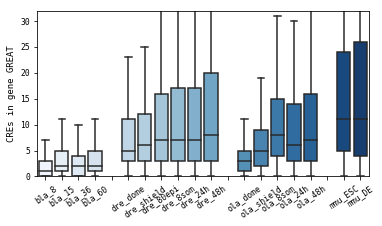

In [14]:
Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth*(9/16.)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.09, bottom=.19, right=.99, top=.99)

# ax.set_title('ATACseq peak numbers overview')
sns.boxplot(data = TOPLOT, 
            x='specstage',
            order=stagespecorder,
            y='count',
           fliersize=0, palette='Blues',
            ax=ax
           )

ax.set_ylim((0,32))
for label in ax.get_xticklabels():
        label.set_rotation(35) 
ax.set_ylabel('CREs per gene GREAT')
ax.set_xlabel('')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_dalton2.pdf')

### Amphi-Zebra 1-X gene categories

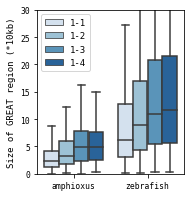

In [16]:
TP = pd.concat(
[TOPLOT[ (TOPLOT.species=='dre') 
        & (TOPLOT.stage=='8som') 
        & (TOPLOT.category!='nop')],
TOPLOT[ (TOPLOT.species=='bla') 
       & (TOPLOT.stage=='15') 
       & (TOPLOT.category!='nop')]
               ])
TP['score'] = TP['score']/10000.
Fwidth = THESIS_PAGEWIDTH/2
Fheight = Fwidth

fig, ax = plt.subplots()
fig.subplots_adjust(left=.18, bottom=.09, right=.98, top=.98)
# ax.set_title('ATACseq peak numbers overview')
sns.boxplot(data = TP,  
            x='species',
            order=['bla','dre'],
            y='score',
            hue='category',
            hue_order=['1-1','1-2','1-3','1-4'],
           fliersize=0, palette='Blues')

ax.set_ylim((0,30))
plt.legend(loc='upper left')
ax.set_xticklabels(['amphioxus','zebrafish'], 
                   rotation = 0, ha="center")
ax.set_ylabel('Size of GREAT region (*10kb)')
ax.set_xlabel('')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_daltonGR.pdf')

### Amphi-Zebra 1-X gene categories (GREAT size)

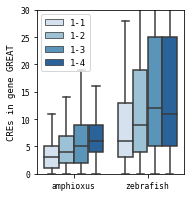

In [17]:
TP = pd.concat(
[TOPLOT[ (TOPLOT.species=='dre') 
        & (TOPLOT.stage=='8som') 
        & (TOPLOT.category!='nop')],
TOPLOT[ (TOPLOT.species=='bla') 
       & (TOPLOT.stage=='15') 
       & (TOPLOT.category!='nop')]
               ])
Fwidth = THESIS_PAGEWIDTH/2
Fheight = Fwidth

fig, ax = plt.subplots()
fig.subplots_adjust(left=.18, bottom=.09, right=.98, top=.98)

# ax.set_title('ATACseq peak numbers overview')
sns.boxplot(data = TP,  
            x='species',
            order=['bla','dre'],
            y='count',
            hue='category',
            hue_order=['1-1','1-2','1-3','1-4'],
           fliersize=0, palette='Blues')

ax.set_ylim((0,30))
plt.legend(loc='upper left')
ax.set_xticklabels(['amphioxus','zebrafish'], 
                   rotation = 0, ha="center")
ax.set_ylabel('CREs in gene GREAT')
ax.set_xlabel('')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_dalton3.pdf')

### All species 1-X gene categories (GREAT size)

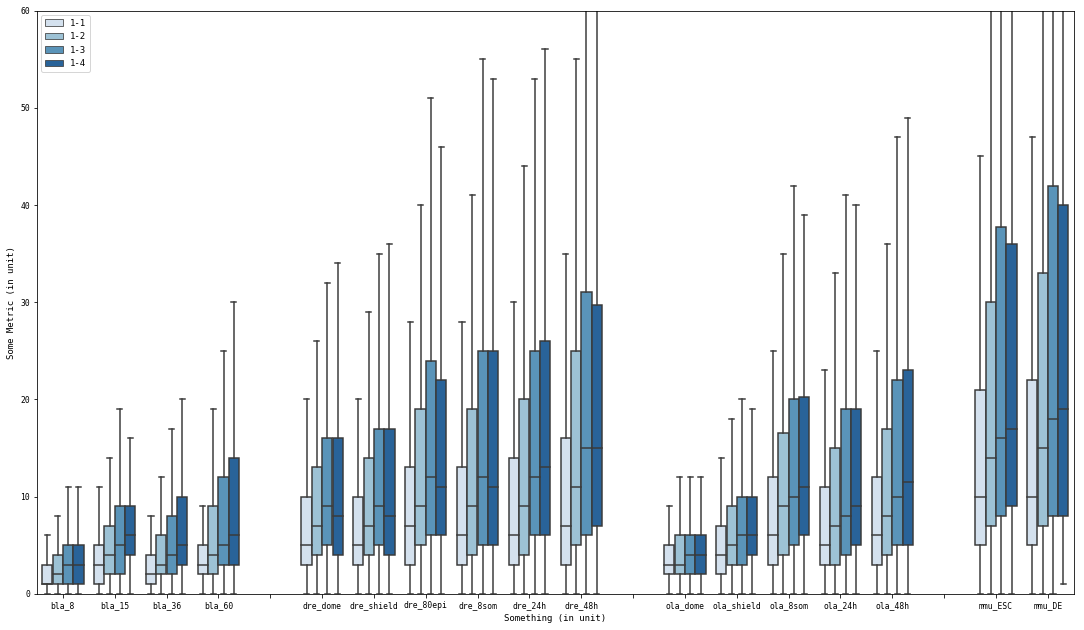

In [15]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.05, bottom=.05, right=.95, top=.95)
Fwidth = 16
Fheight = 9
sns.boxplot(data = TOPLOT, 
            x='specstage',
            order=stagespecorder,
            hue='category',
            hue_order = ['1-1','1-2','1-3','1-4'],
            y='count',
           fliersize=0, palette='Blues',
            ax=ax
           )
ax.set_ylim((0,60))
plt.legend(loc='upper left')
ax.set_ylabel('Some Metric (in unit)')
ax.set_xlabel('Something (in unit)')
fig.set_size_inches(Fwidth, Fheight)

### MinMax in each gene family

In [18]:
# The following goes through our data 
# and extracts the smallest and biggest
# count of peaks in each genomic family
lot = {}
lot['Dre'] = []
lot['Bla'] = []
# for each category ('1-1','1-2' etc)
for mask,title in zip(masks, titles):
    # go through the gene families table
    # and for each family
    for i,row in genefams.loc[mask,['Bla','Dre']].iterrows():
        # for each species
        for spec in ['Bla','Dre']:
            try:
                lgl = row[spec]
                #if there's genes in this family for this species
                if lgl == lgl:
                    slaice = (big_ind[spec]
                              .loc[lgl, stages[spec]])
                    slaice = pd.concat(
                        [slaice.min(),slaice.max()], axis=1)
                    slaice.columns = ['min','max']
                    slaice['stage'] = (
                        spec + "_" + slaice.index.values)
                    slaice = pd.melt(
                        slaice, id_vars=['stage'])
                    slaice['title'] = title
                    
                    lot[spec].append( slaice )
            except:
                pass
lot['Dre'] = pd.concat(lot['Dre'])
lot['Bla'] = pd.concat(lot['Bla'])
bigmelt3 = pd.concat([lot['Dre']
                     , lot['Bla']])

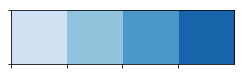

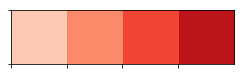

In [19]:
# a hand-made palette
bcp = sns.color_palette('Blues',4)
sns.palplot(bcp)
rcp = sns.color_palette('Reds',4)
sns.palplot(rcp)
mycp = {
'1-1max':(0.90274 ,  0.83764,  0.82901),
'1-1min':(0.99137, 0.79137, 0.70823),
'1-2max':(0.57960, 0.77019, 0.87372),
'1-2min':(0.98745, 0.54117, 0.41568),
'1-3max':(0.29098, 0.59450, 0.78901),
'1-3min':(0.94666, 0.26823, 0.19607),
'1-4max':(0.09019, 0.39294, 0.67058),
'1-4min':(0.73647, 0.08, 0.010117),
'_':(0,0,0)}

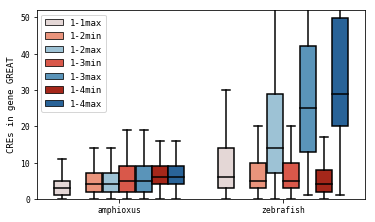

In [20]:
foo = bigmelt3.copy()
foo['nf'] = foo.title + foo.variable
foo['norm'] = 0
toplot = foo.copy()
toplot['hew'] = toplot.title  + toplot.variable

Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth*(9/16.)
fig, ax = plt.subplots()
fig.subplots_adjust(left=.10, bottom=.08, right=.99, top=.99)

g = sns.boxplot(
    x="stage",
    y="value",
    hue="hew",
    fliersize=0,
    hue_order=['1-1max','_','1-2min','1-2max',
               '1-3min','1-3max','1-4min','1-4max'],
    palette = mycp,
    order=['Bla_15','Dre_8som'],
    data=toplot,
    ax=ax
            )

ax.set_ylim((0,52))
ax.set_xticklabels(['amphioxus','zebrafish'])
ax.set_ylabel('CREs in gene GREAT')
ax.set_xlabel('')
plt.legend(loc='upper left')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_dalton4.pdf')

### TransDev / Housekeeping Genes

In [21]:
hkg = pd.read_csv("/home/ska/panos/myphdthesis/data/gene_categories/HouseKeepGenes.tab.gz",
            header=None,sep='\t',usecols=[1,2])

hkg = hkg[hkg[1].isin(['Bla','Dre'])]
hkgenes = hkg[2].values

In [22]:
# We load the housekeeping and later the TD genes
hkg.head(3)

1                   2
1   Bla             BL24571
3   Dre  ENSDARG00000002720
12  Bla             BL05749

In [23]:
tdg = pd.read_csv("/home/ska/panos/myphdthesis/data/gene_categories/TransDevGenes.tab.gz",
            header=None,sep='\t',usecols=[1,2])

tdg = tdg[tdg[1].isin(['Bla','Dre'])]
tdgenes = tdg[2].values

In [24]:
blac = dd_bla.copy()
drec = dd_dre.copy()

In [25]:
# apply our TD and HK labels to the rest of the data
blac['class'] = 'nop'
drec['class'] = 'nop'
blac['class'] = blac.apply(
    lambda x: 'TD' if (x.name in tdgenes) else x['class'],
    axis=1  )
blac['class'] = blac.apply(
    lambda x: 'HK' if (x.name in hkgenes) else x['class'],
    axis=1  )
drec['class'] = drec.apply(
    lambda x: 'TD' if (x.name in tdgenes) else x['class'],
    axis=1  )
drec['class'] = drec.apply(
    lambda x: 'HK' if (x.name in hkgenes) else x['class'],
    axis=1  )

In [24]:
# To get the pvalues for enrichment of TD/HK in 
# each gene category:
from scipy.stats import hypergeom
statf = hypergeom.sf

foo = drec

td_in_population = foo['class'].value_counts()['TD']
hk_in_population = foo['class'].value_counts()['HK']

pop_size = len(foo)
for gn,g in foo.groupby('category'):
    
    ss = len(g)
    td_is = g['class'].value_counts().get('TD',0)
    hk_is = g['class'].value_counts().get('HK',0)
    try:
        print('td',gn,
              statf(td_is,  pop_size,  ss, td_in_population ),
             sep='\t')
        print('hk',gn,
              statf(hk_is,  pop_size,  ss, hk_in_population ),
             sep='\t')
    except:
        continue

td	1-1	1.0
hk	1-1	0.0
td	1-2	1.92058095378e-11
hk	1-2	1.0
td	1-3	4.41908946369e-45
hk	1-3	1.0
td	1-4	4.18209713364e-27
hk	1-4	1.0
td	nop	1.0
hk	nop	0.999999999991


In [26]:
# Bit of a lazy compilation of the data we need:
a = dd_bla.loc[hkg.loc[hkg[1]=='Bla',2].values]
a['class'] = 'House Keeping'
b = dd_bla.loc[tdg.loc[tdg[1]=='Bla',2].values]
b['class'] = 'Trans Dev'
c1 = pd.concat([a,b])
    
a = dd_dre.loc[hkg.loc[hkg[1]=='Dre',2].values]
a['class'] = 'House Keeping'
b = dd_dre.loc[tdg.loc[tdg[1]=='Dre',2].values]
b['class'] = 'Trans Dev'
c2 = pd.concat([a,b])
c = pd.concat([pd.melt(c1, id_vars=['category','class','species']),
        pd.melt(c2, id_vars=['category','class','species'])])

In [27]:
c.head(3)

category          class species variable  value
0      1-1  House Keeping     bla        8      1
1      1-1  House Keeping     bla        8      1
2      1-1  House Keeping     bla        8      2

In [28]:
c['catstage'] = c['species'] + '_' + c.variable

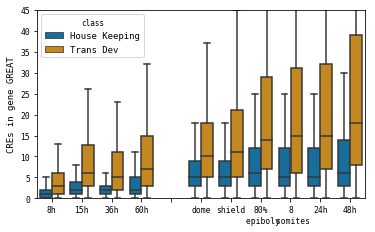

In [29]:
Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth*(9/16.)
fig, ax = plt.subplots()
fig.subplots_adjust(left=.10, bottom=.08, right=.99, top=.99)

_ = sns.boxplot(data=c,
           x='catstage',
            order=stagespecorder[:11],
           y='value',
           hue='class',
           fliersize=0,
            palette=sns.color_palette("colorblind", 8)
           )
ax.set_ylim((0,45))
ax.set_xticklabels(['8h','15h','36h','60h','',
    'dome','shield','80%\n epiboly','8\n somites','24h','48h'],
   rotation=0, ha='center')

ax.set_ylabel('CREs in gene GREAT')
ax.set_xlabel('')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_TDHK.pdf')

### Genes by fate

Here we plot genes split based on how the ohnologues 'behaved' in 
zebrafish. Redundant genes are genes that both copies retain the full
ancestral expression. Subfunctionalized genes lose domains reciprocally,
specialized genes lose domains but at least one ohnologue maintains the
ancestrall expression (spec_equal).
Spec strong genes have lost more domains than spec mild

In [14]:
fate_dict_zebra = dict(
    pd.read_csv("/home/ska/panos/myphdthesis/data/gene_fates/Gene_types-Dre-v3.txt.gz", 
    sep='\t',header=None).set_index(0)[1])
fate_dict_mouse = dict(
    pd.read_csv("/home/ska/panos/myphdthesis/data/gene_fates/Gene_types-Mmu-v3.txt.gz", 
    sep='\t',header=None).set_index(0)[1])

FATE_ORDER = ['REDUNDANT','SUBFUNCT','SPEC_EQUAL', 
              'SPEC_MILD','SPEC_STRONG']

dd_dre['fate'] = dd_dre.index.to_series().map(fate_dict_zebra)
NTP = pd.melt(dd_dre, id_vars=['category','fate','species'])

NTP.columns = ['category','fate','species','stage','count']
NTP['specstage'] = NTP.species + '_' + NTP.stage

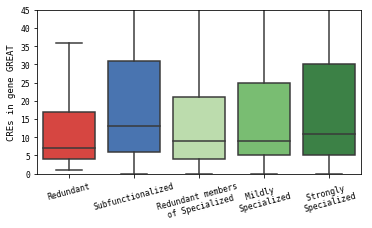

In [16]:
Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth*(9/16.)
fig, ax = plt.subplots()
fig.subplots_adjust(left=.10, bottom=.20, right=.98, top=.99)

_ = sns.boxplot( data=NTP.dropna(), 
           y="count",
           x="fate",            
        fliersize=0,
            order=FATE_ORDER,
                
            palette=["#ef2f28ff",
                    "#3871c1ff",
                     "#b9e4a5ff",
                     "#6fca65ff",
                     "#308d3eff"
                    ]
           )
ax.set_ylim((0,45))
ax.set_xticklabels(['Redundant','Subfunctionalized',
                    'Redundant members\nof Specialized',
                    'Mildly \nSpecialized',
                    'Strongly \nSpecialized'])


ax.set_ylabel('CREs in gene GREAT')
ax.set_xlabel('')
plt.xticks(rotation=15)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_fates.pdf')

### Genes by domain loss

Here we plot genes split based on how many domains of expression
were lost in comparison to an amphioxus orthologue. This was 
computed by our collaborators so we just load the gene lists:

In [42]:
fate_dict_zebra = dict(
    pd.read_csv("/home/ska/panos/myphdthesis/data/gene_fates/Spec_genes_byLost-Dre-v3.txt.gz", 
            sep='\t',header=None).set_index(0)[1])
dd_dre['fate'] = dd_dre.index.to_series().map(fate_dict_zebra)
NTP = pd.melt(dd_dre, id_vars=['category','fate','species'])
NTP.columns = ['category','fate','species','stage','count']
NTP['specstage'] = NTP.species + '_' + NTP.stage

In [43]:
NTP.loc[NTP['fate']>=5,['fate']] = '>=5'

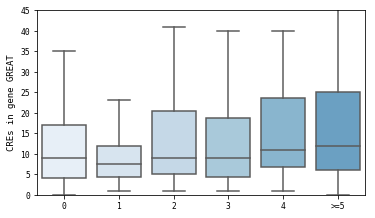

In [45]:
Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth*(9/16.)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.1, bottom=.1, right=.99, top=.99)
_ = sns.boxplot( data=NTP[NTP.stage=='48h'].dropna(), 
           y="count",
           x="fate",            
        fliersize=0,
            order=[0,1,2,3,4,'>=5'],
            palette=sns.color_palette("Blues", 10)
           )
ax.set_ylim((0,45))
ax.set_ylabel('CREs in gene GREAT')
ax.set_xlabel('')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_domlost.pdf')